### LeNet in Pytorch

+ This notebook shows how to use PyTorch (and TorchVision) for Image Classification.  

+ The dataset used is CIFAR-10. 

+ CIFAR-10 defines 10 classes and contains 6K images per class, for a total of 60K images. 

+ 50K Images are used for training and 10K for testing.

+ The images are (32,32) RGBs

        + https://www.cs.toronto.edu/~kriz/cifar.html

+ Images are obtained directly from torchvision.datasets.CIFAR10(args) 

+ The notebook shows how to implement in Pytorch LeNet from scratch.

+ The last cells show how to evaluate the model in general and also there is a cell where the model performance is valuated in terms of each of the 10 classes.

+ The code shows how to connect the model to the GPU, and how to ensire that the data is also loaded into the GPU




In [1]:
# Get general purpose APIs first
import numpy as np
import matplotlib.pyplot as plt

# load the Pytorch APIs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cn1 = nn.Conv2d(3, 6, 5)
        self.cn2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.cn2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
# load the model into the GPU is availabble 
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("LeNet Model params = ", count_params( model))

LeNet Model params =  62006


In [37]:
locBatchSize = 64
# locBatchSize = 200
# locBatchSize = 4096

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize the data.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=locBatchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=locBatchSize,
                                         shuffle=False, num_workers=2)

# order is important ! 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

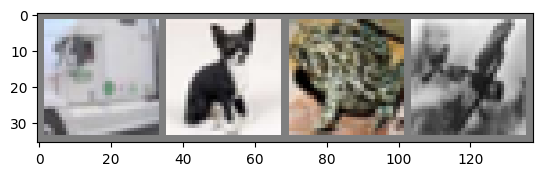

 truck || dog || frog || plane


In [38]:
def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))



In [39]:
# epochs = 20  # Adjust as needed # 01m24s #Accuracy: 64%
# epochs = 40  # Adjust as needed # 03m43s #Accuracy: 61.65 %
epochs = 100  #Adjust as needed # 07m57s #Accuracy: 58%

# Para almacenar la historia de pérdidas (similar a history_torch.history_torch en Keras)
history_torch = {
    'loss': [],
    'val_loss': [],
    'acc': [],
    'val_acc': []
}

# data is loaded into GPU via data[i].to(device)
for epoch in range(epochs):
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # if i % 200 == 199:  # Print every 200 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
        #     running_loss = 0.0

    # Pérdida promedio en el conjunto de entrenamiento parcial
    epoch_loss = running_loss / len(trainset)
    history_torch['loss'].append(epoch_loss)

    # Calcular  accuracy del training para este batch
    predictions = (outputs > 0.5).float()  # Threshold predictions at 0.5
    # print(predictions.size())
    # print(labels.size())    
    train_correct += (predictions.size(1) == labels).sum().item()
    train_total += labels.size(0)

    epoch_acc = train_correct / train_total
    history_torch['acc'].append(epoch_acc)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total

    print(f'Accuracy of the network on the 10000 test images: {val_acc:.2f} %')

    history_torch['val_loss'].append(val_loss)
    history_torch['val_acc'].append(val_acc)    

print('Finished Training')



[1,   200] loss: 1.926
[1,   400] loss: 1.666
[1,   600] loss: 1.570
torch.Size([16, 10])
torch.Size([16])
Accuracy of the network on the 10000 test images: 46.08 %
[2,   200] loss: 1.446
[2,   400] loss: 1.391
[2,   600] loss: 1.367
torch.Size([16, 10])
torch.Size([16])
Accuracy of the network on the 10000 test images: 53.30 %
[3,   200] loss: 1.272
[3,   400] loss: 1.242
[3,   600] loss: 1.238
torch.Size([16, 10])
torch.Size([16])
Accuracy of the network on the 10000 test images: 57.39 %
[4,   200] loss: 1.177
[4,   400] loss: 1.166
[4,   600] loss: 1.153
torch.Size([16, 10])
torch.Size([16])
Accuracy of the network on the 10000 test images: 57.99 %
[5,   200] loss: 1.113
[5,   400] loss: 1.079
[5,   600] loss: 1.088
torch.Size([16, 10])
torch.Size([16])
Accuracy of the network on the 10000 test images: 60.24 %
[6,   200] loss: 1.013
[6,   400] loss: 1.029
[6,   600] loss: 1.049
torch.Size([16, 10])
torch.Size([16])
Accuracy of the network on the 10000 test images: 62.20 %
[7,   200]

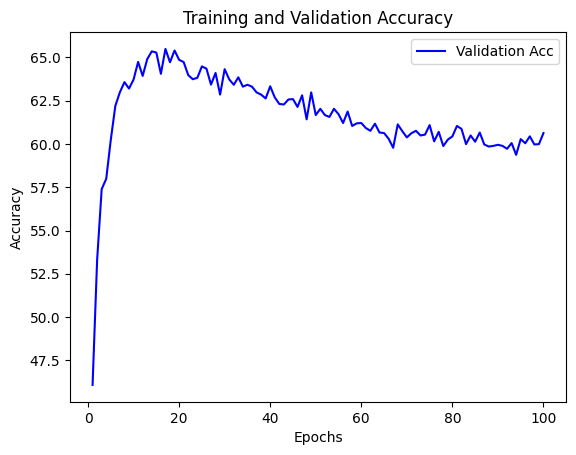

Done


In [40]:
loss_values = history_torch['loss']
# val_loss_values = history_torch['val_loss']
epochs = range(1, len(loss_values) + 1)

# plt.plot(epochs, loss_values, 'bo', label='Training Loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.clf()
acc = history_torch['acc']
val_acc = history_torch['val_acc']

# plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc,'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print ("Done")


### Effect of Batch Size

+ batch_size = 64   => accuracy around 65%
+ batch_size = 4096 => accuracy around 50%


In [10]:
## Save the model to disk 

modelPath = './imgSegExcercise/Playground/'
modelName = modelPath + "LeNet_Cifar10_ACC64.pth"
# modelName = modelPath + "LeNet_Cifar10_E100.pth"
# modelName = modelPath + "LeNet_Cifar10_E100_B64.pth"
torch.save(model.state_dict(), modelName)

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 64.83 %


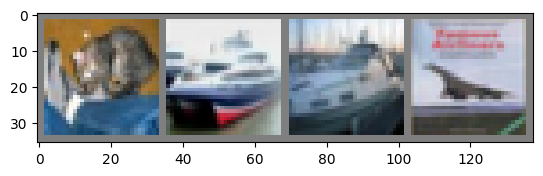

Label:     cat  ship  ship plane
Prediction:   ship   car plane plane
Model accuracy on 10000 images from test dataset: 64 %


In [ ]:
modelName = modelPath + "LeNet_Cifar10_ACC64.pth"
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)
# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:  ', ' '.join('%5s' %
            classes[ground_truth[j]]
            for j in range(4)))

# load model from disk 
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(modelName))
# model inference
op = lenet_cached(im)
# print predictions
_, pred = torch.max(op, 1)
print('Prediction: ', ' '.join('%5s' % classes[pred[j]]
                        for j in range(4)))


#Check accuracy
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()
print('Model accuracy on 10000 images from test dataset: %d %%'\
            % (100 * success / counter))

In [14]:
## Eval per-class accuracy 

class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range( len(ground_truth)) :
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1
for i in range(10):
    print('Accuracy for class %5s : %2d %%' % (
            classes[i], 100 * class_sucess[i] / class_counter[i]))

Accuracy for class plane : 70 %
Accuracy for class   car : 81 %
Accuracy for class  bird : 47 %
Accuracy for class   cat : 38 %
Accuracy for class  deer : 58 %
Accuracy for class   dog : 53 %
Accuracy for class  frog : 76 %
Accuracy for class horse : 70 %
Accuracy for class  ship : 72 %
Accuracy for class truck : 78 %
